In [101]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
import imutils

Ultralytics 8.3.23  Python-3.10.11 torch-2.5.0+cpu CPU (AMD Ryzen 7 3700U with Radeon Vega Mobile Gfx)
Setup complete  (8 CPUs, 5.9 GB RAM, 457.9/476.1 GB disk)


In [247]:
# Modify model path in order to change model
model = YOLO("../models/sudoku_bound_detector_30e.pt")
img_path = "../assets/sudoku14.jpg"

In [248]:
# Function to read images
def read_img(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Return MatLike image format

# Function to display images
def display_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Function to obtain detections
def get_detection(img_path):
    predictions = model.predict(img_path)
    return predictions[0]

# Function to crop box on image
def show_crop_box(img_path):
    image_crop_box = get_crop_box(img_path)
    display_img(image_crop_box)

# Function to crop the first detection
def get_crop_box(img_path):
    prediction = get_detection(img_path)
    orig_img = prediction.orig_img
    coord_crop = torch.tensor(
        [
            [
                int(box[0]),
                int(box[1]),
                int(box[2]),
                int(box[3]),
            ]
            for box in prediction.boxes.xyxy
        ]
    )
    cropped_image = orig_img[
        coord_crop[0][1] : coord_crop[0][3], coord_crop[0][0] : coord_crop[0][2]
    ]
    
    return cropped_image

# Display sudoku area
def display_sudoku(img_path):
    prediction = get_detection(img_path)
    orig_img = prediction.orig_img
    countour = prediction.masks.xy[0]
    
    final_img = correct_area(orig_img, countour)
    
    display_img(final_img)

# Correct sudoku area
def correct_area(orig_img, countour):
    x, y, w, h = cv2.boundingRect(countour)

    side_length = max(w, h)

    epsilon = 0.02 * cv2.arcLength(countour, True)
    approx = cv2.approxPolyDP(countour, epsilon, True)

    if len(approx) != 4:
        src_points = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.float32)
    else:
        src_points = np.array([point[0] for point in approx], dtype=np.float32)

    # Order points in the correct order: top-left, top-right, bottom-right, bottom-left
    src_points = src_points[np.argsort(src_points[:, 1])]
    if src_points[0][0] > src_points[1][0]:
        src_points[[0, 1]] = src_points[[1, 0]]
    if src_points[2][0] < src_points[3][0]:
        src_points[[2, 3]] = src_points[[3, 2]]

    # Define destination points for a square
    dst_points = np.array([[0, 0], [side_length - 1, 0], 
                        [side_length - 1, side_length - 1], [0, side_length - 1]], dtype=np.float32)

    # Compute the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the image to the square output
    warped_square = cv2.warpPerspective(orig_img, matrix, (side_length, side_length))
    
    return warped_square

def clean_image(img):
    proc = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    proc = cv2.GaussianBlur(proc, (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    
    proc = cv2.erode(proc, kernel, iterations=2)
    proc = cv2.dilate(proc, kernel, iterations=3)
    proc = cv2.morphologyEx(proc, cv2.MORPH_CLOSE, kernel)
    
    proc = cv2.bitwise_not(proc, proc)
    
    return proc

# Display a treated image    
def display_corrected_sudoku(img_path):
    prediction = get_detection(img_path)
    orig_img = prediction.orig_img
    countour = prediction.masks.xy[0]

    final_img = clean_image(correct_area(orig_img, countour))

    display_img(final_img)


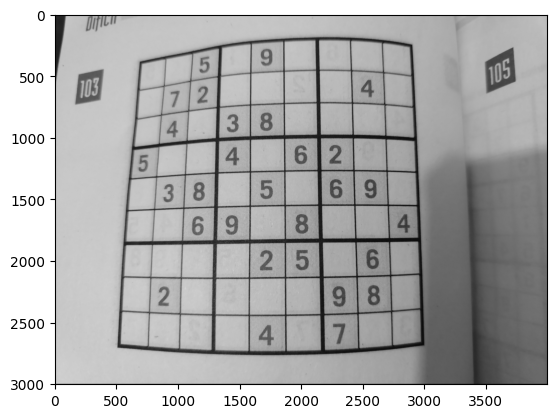

In [249]:
display_img(read_img(img_path))


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku14.jpg: 512x640 1 sudoku, 321.0ms
Speed: 4.0ms preprocess, 321.0ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 640)


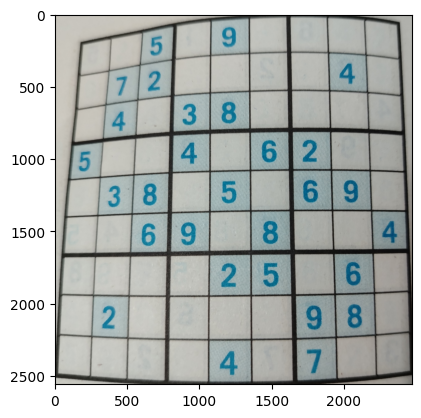

In [250]:
show_crop_box(img_path)


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku14.jpg: 512x640 1 sudoku, 222.6ms
Speed: 4.9ms preprocess, 222.6ms inference, 7.8ms postprocess per image at shape (1, 3, 512, 640)


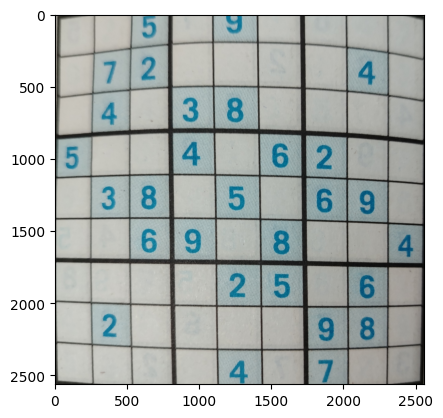

In [251]:
display_sudoku(img_path)


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku14.jpg: 512x640 1 sudoku, 224.9ms
Speed: 6.1ms preprocess, 224.9ms inference, 7.0ms postprocess per image at shape (1, 3, 512, 640)


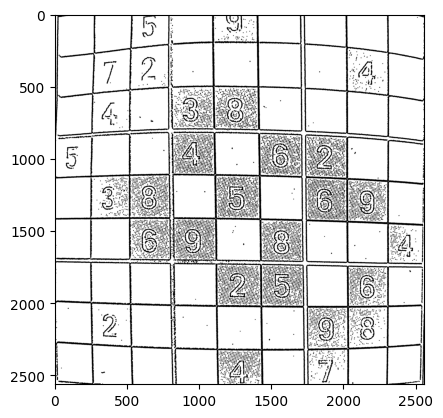

In [252]:
display_corrected_sudoku(img_path)


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku1.jpg: 480x640 1 sudoku, 254.0ms
Speed: 14.0ms preprocess, 254.0ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku2.jpg: 640x512 1 sudoku, 208.1ms
Speed: 4.0ms preprocess, 208.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku3.jpg: 640x640 1 sudoku, 343.4ms
Speed: 10.7ms preprocess, 343.4ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku4.jpg: 640x480 1 sudoku, 205.0ms
Speed: 4.0ms preprocess, 205.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\User

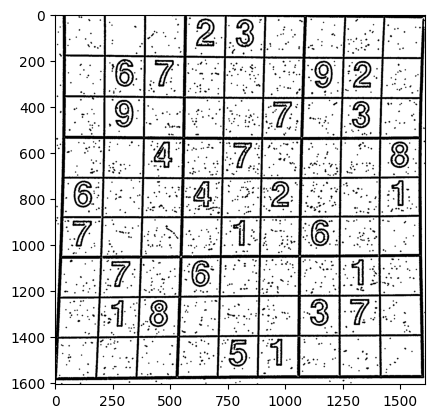

In [253]:
for i in range(1, 10):
    display_corrected_sudoku(f"../assets/sudoku{i}.jpg")

In [302]:
i = 1


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku0.jpg: 640x480 1 sudoku, 188.0ms
Speed: 5.0ms preprocess, 188.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


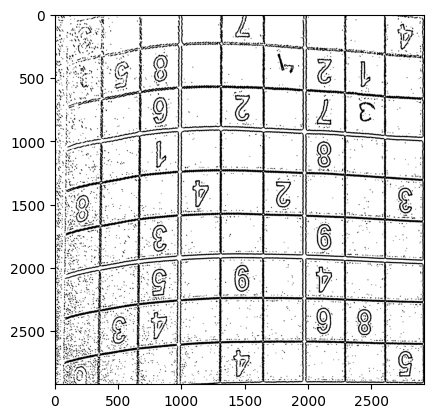

In [320]:
i = i % 18
display_corrected_sudoku(f"../assets/sudoku{i}.jpg")
i += 1